# Analytical uncertainty at CO<sub>2</sub> measurement stations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_style='text')

import matplotlib.pyplot as plt

import figure_panels
import obs_surface
import util

## Load the monthly data

Specify the records at each station to examine.

In [3]:
stn_records = dict(
    SPO=[
        'SPO_NOAA_insitu_CO2',
        'SPO_NOAA_flask_CO2',
        'SPO_SIO_O2_flask_CO2',
        'SPO_CSIRO_flask_CO2',
        'SPO_SIO_CDK_flask_CO2',    
    ],
    CGO=[
        'CGO_CSIRO_insitu_CO2',
        'CGO_NOAA_flask_CO2',
        'CGO_CSIRO_flask_CO2',
        'CGO_SIO_O2_flask_CO2',
    ],
)
record_list = [ri for r in stn_records.values() for ri in r]

1. Read txt file containing the station data.
1. Make all records into a dataset for later plotting.
1. Compute mean across records at each station and generate "anomaly" columns.

In [4]:
# generate column names for the "anomaly" columns (minus station mean)
stn_records_a = dict()
for stn, records in stn_records.items():
    stn_records_a[stn] = [f'{rec}_mmedian' for rec in records]
    
# read monthly data
file = obs_surface.data_files('CO2', 'obs')
df = obs_surface.read_stndata(file)

# get dataset
stninfo = obs_surface.get_stn_info('CO2')
ds = obs_surface.to_dataset(
    stninfo, df, 'CO2', 
    plot_coverage=False, 
    dropna=False, 
    unique_stn=False, 
    gap_fill=False).to_dataset()

# keep only columns from stations specified above
df = df[filter(lambda s: '_CO2' in s and 
               any(s in records for records in stn_records.values()) 
               or '_CO2' not in s, df.columns)]

# compute station median and add as new columns
for (stn, arecords), records in zip(stn_records_a.items(), stn_records.values()):
    df[stn] = df[records].median(axis=1)
    df[arecords] = df[records].sub(df[stn], axis=0)
df

,year,month,day,year_frac,polar_year,SPO_SIO_CDK_flask_CO2,SPO_NOAA_flask_CO2,CGO_NOAA_flask_CO2,SPO_NOAA_insitu_CO2,SPO_SIO_O2_flask_CO2,...,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
date,,,,,,,,,,,,,,,,,,,,,
1998-12-15,1998,12,15.5,1998.956164,1999,365.0013,365.1300,364.9250,365.0870,365.0911,...,-0.00205,0.04095,0.00205,NaN,-0.08775,364.88090,NaN,0.04410,0.00000,-0.12380
1999-01-15,1999,1,15.5,1999.041096,1999,364.9615,365.1871,364.9575,365.0233,365.0878,...,-0.06450,0.09930,0.00000,0.1202,-0.12630,364.95750,NaN,0.00000,-0.01010,0.02390
1999-02-14,1999,2,14.0,1999.123288,1999,364.7820,365.0420,365.0900,364.9477,364.9615,...,-0.01380,0.08050,0.00000,0.1495,-0.17950,365.09000,NaN,0.00000,0.10910,-0.05870
1999-03-15,1999,3,15.5,1999.202740,1999,364.8418,365.0717,364.8880,364.8559,364.8717,...,-0.01580,0.20000,0.00000,0.1283,-0.02990,364.84690,NaN,0.04110,0.00000,-0.15130
1999-04-15,1999,4,15.0,1999.287671,1999,365.0213,365.1425,364.9900,365.0247,365.0562,...,0.00000,0.11780,0.03150,-0.0907,-0.00340,364.99000,NaN,0.00000,0.04870,-0.08340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15,2019,10,15.5,2019.789041,2020,408.8537,408.8583,408.6825,408.8633,408.7191,...,0.00960,0.00460,-0.13460,-0.1977,0.00000,408.68835,0.13025,-0.00585,0.00585,-0.20365
2019-11-15,2019,11,15.0,2019.873973,2020,408.8636,408.8800,408.8037,408.9070,408.7589,...,0.04340,0.01640,-0.10470,-0.0246,0.00000,408.75905,0.00675,0.04465,-0.00675,-0.14465
2019-12-15,2019,12,15.5,2019.956164,2020,409.0132,408.9975,408.5017,408.8532,408.8587,...,-0.08780,0.05650,-0.08230,0.0000,0.07220,408.51000,0.00830,-0.00830,0.17730,-0.08510


## Compute the long-term standard deviation of monthly records

In [5]:
print('Long-term std dev of monthly records:')
for stn, records in stn_records_a.items():
    print(f'{stn}: {np.nanstd(df[records].values):0.4f}')

Long-term std dev of monthly records:
SPO: 0.1269
CGO: 0.1077


## Compute seasonal means

Loop over the seasons and generate seasonal averages. 

Require at least 2 months to define a season.

In [6]:
seasons = OrderedDict([
    ('djf', [12, 1, 2]),
    ('mam', [3, 4, 5]),
    ('jja', [6, 7, 8]),
    ('son', [9, 10, 11]),
])
dfs_seasons = {}
for season, months in seasons.items():
    if season == 'djf':
        groupby_col = 'polar_year'
        drop_cols = ['month', 'day', 'year']        
    else:
        groupby_col = 'year'
        drop_cols = ['month', 'day', 'polar_year']

    grouped = df.loc[df.month.isin(months)].groupby(groupby_col)
    
    dfs_seasons[season] = grouped.mean().where(grouped.count()>=2)
    dfs_seasons[season] = dfs_seasons[season].set_index('year_frac')
    dfs_seasons[season] = dfs_seasons[season].drop(drop_cols, axis=1)
    
dfs_seasons['son']

,SPO_SIO_CDK_flask_CO2,SPO_NOAA_flask_CO2,CGO_NOAA_flask_CO2,SPO_NOAA_insitu_CO2,SPO_SIO_O2_flask_CO2,CGO_CSIRO_flask_CO2,CGO_SIO_O2_flask_CO2,CGO_CSIRO_insitu_CO2,SPO_CSIRO_flask_CO2,SPO,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
year_frac,,,,,,,,,,,,,,,,,,,,
1999.789954,366.546833,366.635833,366.485433,366.652033,366.636567,366.551133,366.157433,NaN,366.622667,366.622467,0.029567,0.013367,0.014100,0.000200,-0.075633,366.485433,NaN,0.000000,0.065700,-0.328000
2000.790528,367.783267,367.738800,367.676267,367.886567,367.929467,367.733767,367.617033,NaN,367.693000,367.781900,0.104667,-0.043100,0.147567,-0.057400,0.001367,367.676267,NaN,0.000000,0.057500,-0.059233
2001.789954,369.528167,369.689367,369.552500,369.798500,369.716500,369.554000,369.451733,NaN,369.600500,369.693767,0.104733,-0.004400,0.022733,-0.093267,-0.165600,369.536233,NaN,0.016267,0.017767,-0.084500
2002.789954,371.808200,371.904767,371.783767,371.996267,371.917867,371.837167,371.803200,NaN,371.861000,371.876567,0.119700,0.028200,0.041300,-0.015567,-0.068367,371.800600,NaN,-0.016833,0.036567,0.002600
2003.789954,373.815700,374.006367,373.887233,374.085800,374.045000,373.939467,373.765833,NaN,373.976000,374.013700,0.072100,-0.007333,0.031300,-0.037700,-0.198000,373.891167,NaN,-0.003933,0.048300,-0.125333
2004.790528,375.593833,375.782367,375.600400,375.713767,375.909600,375.692033,375.218267,375.657567,375.832500,375.782883,-0.069117,-0.000517,0.126717,0.029450,-0.189050,375.616933,0.040633,-0.016533,0.075100,-0.398667
2005.789954,377.834000,377.895200,377.713633,377.916767,377.955333,377.910333,377.662800,377.874400,377.801500,377.896867,0.019900,-0.001667,0.058467,-0.094300,-0.062867,377.800133,0.074267,-0.086500,0.110200,-0.137333
2006.789954,379.322967,379.597367,379.468500,379.542000,379.558933,379.405733,379.266467,379.442533,379.590500,379.546483,-0.004483,0.050883,0.012450,0.000000,-0.223517,379.406117,0.036417,0.062383,-0.000383,-0.139650
2007.789954,381.619633,381.868867,381.553600,381.748333,381.835667,381.596667,381.519933,381.721733,NaN,381.775933,-0.027600,0.092933,0.059733,NaN,-0.156300,381.586500,0.135233,-0.032900,0.010167,-0.066567


## Long-term seasonal means

In [7]:
# make list of *all* records
records = [record for stn, records in stn_records_a.items() for record in records]

# dimension dictionary with lists
df_mean = {'season': list(seasons.keys())}
df_mean.update({r: [] for r in records})

# loop over seasons, compute long-term mean
for season in seasons:
    for r in records:
        df_mean[r].append(dfs_seasons[season][r].mean(axis=0))
df_mean = pd.DataFrame(df_mean).set_index('season')
df_mean

,SPO_NOAA_insitu_CO2_mmedian,SPO_NOAA_flask_CO2_mmedian,SPO_SIO_O2_flask_CO2_mmedian,SPO_CSIRO_flask_CO2_mmedian,SPO_SIO_CDK_flask_CO2_mmedian,CGO_CSIRO_insitu_CO2_mmedian,CGO_NOAA_flask_CO2_mmedian,CGO_CSIRO_flask_CO2_mmedian,CGO_SIO_O2_flask_CO2_mmedian
season,,,,,,,,,
djf,-0.017290,0.024567,-0.004355,0.106728,-0.056947,0.004599,0.027571,0.007436,-0.068187
mam,0.039309,0.006748,-0.035228,-0.040449,-0.001835,0.061413,-0.005066,-0.009310,-0.039366
jja,0.067344,-0.003321,-0.036373,-0.078673,0.015745,0.032955,0.004226,-0.000957,-0.056112
son,0.021917,0.021340,-0.005043,-0.016149,-0.058767,0.043461,-0.004791,0.037020,-0.118329


## SD of the long-term mean at each station

In [8]:
error = {'season': list(seasons.keys())}
error.update({stn: [] for stn in stn_records.keys()})
for stn, arecords in stn_records_a.items():
    for season in seasons:
        error[stn].append(df_mean.loc[season][arecords].std(ddof=1))

df_error = pd.DataFrame(error).set_index('season')
df_error

,SPO,CGO
season,,
djf,0.061237,0.041960
mam,0.032685,0.042500
jja,0.054904,0.037213
son,0.033189,0.074899


## Median across records at SPO and CGO

In [9]:
ds_mSPO_med = (ds.sel(record=stn_records['SPO']) - ds.sel(record=stn_records['SPO']).median('record', skipna=True))
ds_mCGO_med = (ds.sel(record=stn_records['CGO']) - ds.sel(record=stn_records['CGO']).median('record', skipna=True))
ds_m_med = xr.concat((ds_mSPO_med, ds_mCGO_med), 'record')
ds_m_med.record

<xarray.DataArray 'record' (record: 9)>
array(['SPO_NOAA_insitu_CO2', 'SPO_NOAA_flask_CO2', 'SPO_SIO_O2_flask_CO2',
       'SPO_CSIRO_flask_CO2', 'SPO_SIO_CDK_flask_CO2', 'CGO_CSIRO_insitu_CO2',
       'CGO_NOAA_flask_CO2', 'CGO_CSIRO_flask_CO2', 'CGO_SIO_O2_flask_CO2'],
      dtype=object)
Coordinates:
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CGO_SIO_O2_flask_...
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'CSIRO' 'SIO_O2'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -40.68 -40.68
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 144.7 144.7
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'CGO' 'CGO'

## Seasonal means of the medians

In [10]:
ds_djf = util.ann_mean(ds_m_med, season='DJF', time_bnds_varname=None, n_req=2,)
ds_jja = util.ann_mean(ds_m_med, season='JJA', time_bnds_varname=None, n_req=2,)

ds_djf.time

<xarray.DataArray 'time' (time: 22)>
array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1999 2000 2001 2002 2003 ... 2016 2017 2018 2019 2020

## Time series of SPO and CGO records

<Figure size 432x576 with 0 Axes>

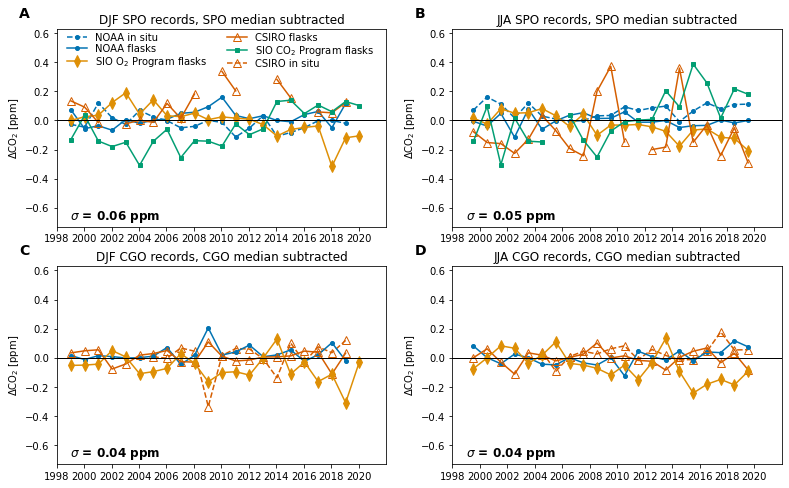

In [11]:
fig = plt.figure(figsize=(6, 8))

ncol = 2
nrow = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6.5*ncol, 4*nrow))   

marker_spec = figure_panels.marker_spec_co2_inst()

labels = dict(
    SPO_NOAA_insitu_CO2='NOAA in situ',
    SPO_NOAA_flask_CO2='NOAA flasks',
    SPO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    SPO_SIO_CDK_flask_CO2='SIO CO$_2$ Program flasks',
    SPO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_NOAA_flask_CO2='NOAA flasks',
    CGO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    CGO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_CSIRO_insitu_CO2='CSIRO in situ',
)

def ammendments(ax):
    ax.axhline(0, color='k', lw=1);
    ax.set_ylabel('$\Delta$CO$_2$ [ppm]')    
    ax.set_xticks(np.arange(1998, 2022, 2));
    ax.set_xlim([1998, 2022])
    ax.set_ylim([-0.73, 0.63]);

plotted_elements = []
legend_elements = []
    
    
dset = ds_djf.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['DJF']
for i, record in enumerate(dset.record.values):    
    ax = axs[0, 0] if 'SPO' in record else axs[1, 0]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
        
    inst = str(dset.sel(record=record).institution.values)
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])


dset = ds_jja.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['JJA']
for i, record in enumerate(dset.record.values):
    ax = axs[0, 1] if 'SPO' in record else axs[1, 1]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
    inst = str(dset.sel(record=record).institution.values)    
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])

for ax in axs.ravel():
    ammendments(ax)

    
xoff = 1
yoff = 0.05
str_text = f'$\sigma$ = {df_error.loc["djf"].SPO:0.2f} ppm'
axs[0, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["djf"].CGO:0.2f} ppm'
axs[1, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].SPO:0.2f} ppm'
axs[0, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].CGO:0.2f} ppm'
axs[1, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )    
          
axs[0, 0].set_title('DJF SPO records, SPO median subtracted')
axs[1, 0].set_title('DJF CGO records, CGO median subtracted')


axs[0, 1].set_title('JJA SPO records, SPO median subtracted')
axs[1, 1].set_title('JJA CGO records, CGO median subtracted')

util.label_plots(fig, [ax for ax in axs.ravel()])

axs[0, 0].legend(handles=legend_elements, ncol=2, loc=(0.02, 0.78), frameon=False, labelspacing=0.1)

util.savefig('SPO-CGO-record-discrepancies')